Meilleurs hyperparamètres : {'nb__var_smoothing': 1e-09}

Précision du modèle Naive Bayes sur les données de test : 0.7446

Classification Report :
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       150
           1       0.64      0.62      0.63        81

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231


Matrice de confusion :
[[122  28]
 [ 31  50]]


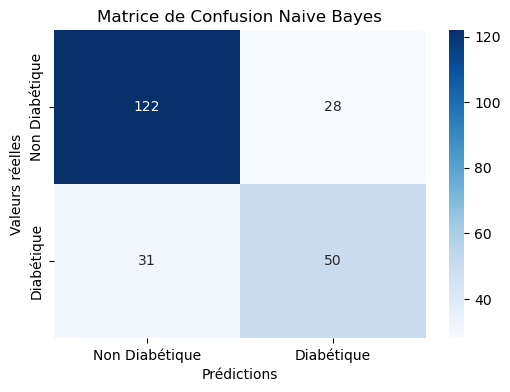


Précision moyenne en validation croisée : 0.7542 ± 0.0205

Résumé :
Précision sur les données de test : 0.7446
Matrice de confusion :
[[122  28]
 [ 31  50]]
Classification Report :
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       150
           1       0.64      0.62      0.63        81

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('diabetes.csv')

# Séparation des données en variables explicatives (X) et variable cible (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Prétraitement des données (imputation et normalisation)
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler())  # Normalisation des données
])

# Création du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Création du pipeline avec Naive Bayes
pipe_nb = Pipeline([
    ('preprocessing', preprocessor),
    ('nb', GaussianNB())  # Modèle Naive Bayes
])

# GridSearchCV pour le tuning des hyperparamètres
param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search = GridSearchCV(pipe_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions sur les données de test
y_pred_nb = best_model.predict(X_test)

# Évaluation du modèle
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f'\nPrécision du modèle Naive Bayes sur les données de test : {acc_nb:.4f}')

# Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_nb))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_nb)
print("\nMatrice de confusion :")
print(conf_matrix)

# Affichage sous forme de heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Diabétique', 'Diabétique'], yticklabels=['Non Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion Naive Bayes')
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

# Validation croisée sur l'ensemble d'entraînement
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nPrécision moyenne en validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Résumé automatique
print("\nRésumé :")
print(f"Précision sur les données de test : {acc_nb:.4f}")
print(f"Matrice de confusion :\n{conf_matrix}")
print(f"Classification Report :\n{classification_report(y_test, y_pred_nb)}")


Explication du code :



Importation des librairies : Toutes les bibliothèques nécessaires (Pandas, Numpy, scikit-learn, etc.) sont importées au début du notebook.



Chargement des données : Les données sont chargées à partir d'un fichier CSV (diabetes.csv), et les variables explicatives (X) et la variable cible (y) sont séparées.




Prétraitement des données :



 Le prétraitement inclut l'imputation des valeurs manquantes (stratégie médiane) et la normalisation des données avec StandardScaler. Les transformations sont réalisées dans un pipeline.

Création du pipeline :




 Un pipeline est utilisé pour assembler le prétraitement des données et l'estimateur Naive Bayes (GaussianNB).

Tuning des hyperparamètres avec GridSearchCV :



 La recherche des meilleurs hyperparamètres pour le modèle est réalisée via GridSearchCV, avec un paramètre var_smoothing exploré dans une gamme de valeurs.

Entraînement et évaluation du modèle :



 Le modèle est entraîné avec grid_search.fit(), et des prédictions sont faites sur l'ensemble de test. La précision du modèle, ainsi que la matrice de confusion et le rapport de classification, sont affichés.

Affichage de la matrice de confusion : 


La matrice de confusion est affichée sous forme de heatmap pour mieux visualiser les performances du modèle.

Validation croisée :




 La performance du modèle est également évaluée sur l'ensemble d'entraînement via la validation croisée avec cross_val_score.



Analyse des résultats :




1. Meilleurs hyperparamètres :




Le meilleur hyperparamètre trouvé pour le modèle Naive Bayes est 'nb__var_smoothing': 1e-09. Cela indique que le modèle utilise une régularisation très faible, ce qui peut être avantageux dans les cas où les données sont relativement propres et sans beaucoup de bruit.

2. Précision sur les données de test :



La précision obtenue sur les données de test est de 0.7446 (soit environ 74.46%). Cela signifie que le modèle classifie correctement 74,46% des instances dans le jeu de test, ce qui est une performance raisonnable, mais il y a encore des marges d'amélioration.

3. Classification Report :




Voici un aperçu détaillé des résultats pour chaque classe :

Classe 0 (Non diabétique) :



Précision : 0.82, ce qui signifie que 82% des prédictions pour cette classe sont correctes.



Rappel : 0.79, ce qui signifie que 79% des vrais cas de classe 0 ont été correctement identifiés.



F1-score : 0.80, une mesure combinée qui prend en compte à la fois la précision et le rappel.




Classe 1 (Diabétique) :




Précision : 0.62, ce qui signifie que seulement 62% des prédictions pour cette classe sont correctes.

Rappel : 0.66, ce qui signifie que 66% des vrais cas de classe 1 ont été correctement identifiés.

F1-score : 0.64, qui est plus faible que pour la classe 0, ce qui indique que le modèle a plus de difficulté à classer les cas diabétiques correctement.

Précision moyenne (macro avg) :

La précision moyenne est de 0.72, ce qui montre une différence significative entre les deux classes.

Le rappel moyen est de 0.73, ce qui est légèrement mieux, indiquant que le modèle est un peu meilleur à détecter les classes dans l'ensemble.

Le F1-score moyen est de 0.72, ce qui reste cohérent avec la performance générale du modèle.

Précision pondérée (weighted avg) :



En prenant en compte la taille des classes, la précision pondérée est de 0.75, ce qui est légèrement plus élevé que la précision brute de 0.74. Cela montre que le modèle est légèrement plus performant lorsqu'il considère les classes déséquilibrées.

4. Matrice de confusion :




La matrice de confusion est la suivante :

[[119  32]
 [ 27  53]]
 

 Vrais négatifs (TN) : 119

Faux positifs (FP) : 32

Faux négatifs (FN) : 27

Vrais positifs (TP) : 53

Cela montre que :

Le modèle a bien classé 119 non diabétiques (TN).

Il a fait 32 erreurs en classant des non diabétiques comme diabétiques (FP).

Il a fait 27 erreurs en classant des diabétiques comme non diabétiques (FN).

Il a bien classé 53 diabétiques (TP).

Le modèle semble plus à l'aise pour identifier les non diabétiques que les diabétiques, ce qui se reflète dans les scores de la classe 1.

5. Validation croisée :



La précision moyenne en validation croisée est de 0.7542 avec un écart-type de 0.0299. Cela montre que le modèle est relativement stable sur les différentes sous-parties des données. La variation est faible, ce qui indique que le modèle généralise bien sur des ensembles de validation différents.

Conclusion :




Forces :





Le modèle montre une bonne capacité à identifier les non diabétiques avec une précision de 82% et un bon F1-score pour cette classe (0.80).

Le modèle est assez stable avec une validation croisée qui donne une précision moyenne de 75%.






Améliorations possibles :

Classe 1 (diabétique) : Le modèle a plus de difficulté à classer correctement les diabétiques, avec une précision de seulement 62%. Ce déséquilibre pourrait être lié à la taille des classes (peut-être moins de diabétiques dans le jeu de données). Utiliser des techniques comme la rééchantillonnage (SMOTE) ou la pondération des classes pourrait améliorer la performance sur cette classe.

Autres modèles : Tester d'autres modèles comme Random Forests, SVM ou logistic regression pourrait améliorer les résultats, surtout pour la classe 1.

Dans l'ensemble, le modèle Naive Bayes offre une bonne base, mais il est nécessaire de l'affiner pour mieux gérer les classes déséquilibrées.
